# Лабораторная работа № 1
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark

## Часть 1
В данной части работы рассмотрены:

* разведочный анализ данных;
* работа с Dataframe API фреймворка `Apache Spark`.

Подключаем необходимые библиотеки.

In [81]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, first,
    year, month, dayofmonth, length,
    from_unixtime, row_number, countDistinct,
    stddev, min, max, to_date, date_format
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для Apache Spark, указав необходимые параметры.

In [35]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.
    """
    conf = SparkConf()
    conf.setAppName("lab 1 Movies EDA")
    conf.setMaster("local[*]")
    conf.set("spark.sql.adaptive.enabled", "true")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "1")
    conf.set("spark.driver.memory", "7g")
    conf.set("spark.driver.cores", "1")
    conf.set("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9820")
    conf.set("spark.hadoop.dfs.client.use.datanode.hostname", "true")
    conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
    return conf




Создаём сам объект конфигурации.

In [36]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark.`

In [37]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Укажем базу данных, которая была создана в первой части лабораторной работы.

In [38]:
df = spark.read.parquet("hdfs://hadoop-namenode:9820/data/mattiev_database/movies_lab1_parquet_table")

Выведем данные, которые были получены ранее.

In [39]:
df.show(10)
df.printSchema()

+--------------------+--------------+--------------------+--------------------+-------+--------------------+--------------+----------+
|                asin|    reviewerID|        reviewerName|          reviewText|overall|             summary|unixReviewTime|reviewTime|
+--------------------+--------------+--------------------+--------------------+-------+--------------------+--------------+----------+
| Not so good: the...|          NULL|                NULL| it's scope was c...|   NULL|                NULL|          NULL|      NULL|
|             Alright|          NULL|                NULL|                NULL|   NULL|                NULL|          NULL|      NULL|
|3 1/2 stars round...|          NULL|                NULL|         trashcanman|   NULL|                   4|          NULL|      NULL|
|          B0029Z8KK6| AYJVVATZH32YP|                 pj1|it is very nice t...|    5.0|          Five Stars|    1523577600|      NULL|
|          B0029Z8KK6|A2GHRRRM85HYX0|          Zach Sat

Функция анализа пропущенных значений во всех столбцах.

In [40]:
def analyze_missing_values(data: DataFrame) -> None:
    print("=== АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===")
    
    total_count = data.count()
    for column in data.columns:
        null_count = data.filter(col(column).isNull()).count()
        null_percentage = (null_count / total_count) * 100
        print(f"{column}: {null_count} пропусков ({null_percentage:.2f}%)")

Выполним функцию анализа пропущенных значений.

In [41]:
analyze_missing_values(df)

=== АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===
asin: 265 пропусков (0.00%)
reviewerID: 4034232 пропусков (30.51%)
reviewerName: 4642944 пропусков (35.11%)
reviewText: 2192918 пропусков (16.58%)
overall: 4459472 пропусков (33.72%)
summary: 4948349 пропусков (37.42%)
unixReviewTime: 5750734 пропусков (43.49%)
reviewTime: 10315311 пропусков (78.01%)


Функция для обработки NULL значений

In [42]:
def handle_null_values(data: DataFrame) -> DataFrame:
    print("=== ОБРАБОТКА NULL ЗНАЧЕНИЙ ===")
    
    # Заменяем NULL в строковых полях на 'Unknown'
    string_columns = [f.name for f in data.schema.fields 
                     if f.dataType.simpleString() in ['string', 'varchar']]
    
    cleaned_data = data
    for column in string_columns:
        null_count = cleaned_data.filter(col(column).isNull()).count()
        if null_count > 0:
            cleaned_data = cleaned_data.fillna({column: "Unknown"})
            print(f"Заменено NULL в {column}: {null_count} значений")
    
    # Преобразуем unixReviewTime в reviewTime если reviewTime NULL
    null_reviewtime_count = cleaned_data.filter(
        col("reviewTime").isNull() & col("unixReviewTime").isNotNull()
    ).count()
    
    if null_reviewtime_count > 0:
        cleaned_data = cleaned_data.withColumn(
            "reviewTime",
            when(
                col("reviewTime").isNull() & col("unixReviewTime").isNotNull(),
                from_unixtime(col("unixReviewTime"), "yyyy-MM-dd")
            ).otherwise(col("reviewTime"))
        )
        print(f"Преобразовано unixReviewTime в reviewTime: {null_reviewtime_count} значений")
    
    print("=== ОБРАБОТКА NULL ЗАВЕРШЕНА ===\\n")
    return cleaned_data

Функция для анализа проблемных данных перед очисткой

In [43]:
def analyze_problematic_data(data: DataFrame) -> None:
    print("=== АНАЛИЗ ПРОБЛЕМНЫХ ДАННЫХ ===")
    
    # Проблемные ASIN
    problematic_asin = data.filter(
        ~col("asin").rlike(r"^[A-Z0-9]{10}$") | 
        (length(col("asin")) != 10)
    ).select("asin").distinct().limit(10)
    
    print("Примеры проблемных ASIN:")
    problematic_asin.show(truncate=False)
    
    # Проблемные reviewerID
    problematic_reviewerid = data.filter(
        col("reviewerID").isNull() | 
        ~col("reviewerID").rlike(r"^[A-Z0-9]{1,50}$")
    ).select("reviewerID").distinct().limit(10)
    
    print("Примеры проблемных reviewerID:")
    problematic_reviewerid.show(truncate=False)
    
    # Проблемные оценки
    problematic_ratings = data.filter(
        col("overall").isNull() | 
        ~col("overall").between(1.0, 5.0)
    ).select("overall").distinct()
    
    print("Проблемные оценки:")
    problematic_ratings.show()
    
    # Проблемные timestamp
    problematic_timestamp = data.filter(
        col("unixReviewTime").isNull() | 
        ~col("unixReviewTime").rlike(r"^[0-9]{1,15}$") |
        (col("unixReviewTime") < 946684800)  # До 2000 года
    ).select("unixReviewTime").distinct().limit(10)
    
    print("Проблемные unixReviewTime:")
    problematic_timestamp.show()
    
    # Проблемные reviewTime (после преобразования)
    problematic_reviewtime = data.filter(
        col("reviewTime").isNull()
    ).count()
    
    print(f"Оставшиеся NULL в reviewTime: {problematic_reviewtime}")

Функция для очистки данных по шаблонам

In [44]:

def clean_data_by_patterns(data: DataFrame) -> DataFrame:
    print("=== НАЧАЛО ОЧИСТКИ ДАННЫХ ПО ШАБЛОНАМ ===")
    
    initial_count = data.count()
    print(f"Начальное количество строк: {initial_count}")
    
    # Шаблоны для каждого столбца
    patterns = {
        "asin": r"^[A-Z0-9]{10}$",  # ASIN обычно 10 символов (буквы и цифры)
        "reviewerID": r"^[A-Z0-9]{1,50}$",  # ID рецензента (только буквы и цифры)
        "reviewerName": r"^[a-zA-Z0-9\s\.\-]{1,100}$",  # Имя (буквы, цифры, пробелы, точки, дефисы)
        "overall": r"^[1-5](\.0)?$",  # Оценка от 1.0 до 5.0
        "unixReviewTime": r"^[0-9]{1,15}$",  # Unix timestamp (только цифры)
    }
    
    # Применяем фильтры для каждого столбца
    cleaned_data = data
    
    # ASIN - должен быть 10 символов, только буквы и цифры
    cleaned_data = cleaned_data.filter(
        col("asin").rlike(patterns["asin"]) & 
        (length(col("asin")) == 10)
    )
    print(f"После фильтрации ASIN: {cleaned_data.count()} строк")
    
    # reviewerID - не NULL и соответствует шаблону
    cleaned_data = cleaned_data.filter(
        col("reviewerID").isNotNull() & 
        col("reviewerID").rlike(patterns["reviewerID"])
    )
    print(f"После фильтрации reviewerID: {cleaned_data.count()} строк")
    
    # reviewerName - может быть NULL, но если есть - должен соответствовать шаблону
    cleaned_data = cleaned_data.filter(
        col("reviewerName").isNull() | 
        col("reviewerName").rlike(patterns["reviewerName"])
    )
    print(f"После фильтрации reviewerName: {cleaned_data.count()} строк")
    
    # overall - оценка от 1.0 до 5.0
    cleaned_data = cleaned_data.filter(
        col("overall").isNotNull() & 
        col("overall").between(1.0, 5.0)
    )
    print(f"После фильтрации overall: {cleaned_data.count()} строк")
    
    # unixReviewTime - должен быть числом и разумным timestamp (после 2000 года)
    cleaned_data = cleaned_data.filter(
        col("unixReviewTime").isNotNull() & 
        col("unixReviewTime").rlike(patterns["unixReviewTime"]) &
        (col("unixReviewTime") >= 946684800)  # 2000-01-01
    )
    print(f"После фильтрации unixReviewTime: {cleaned_data.count()} строк")
    
    # reviewText - если не NULL, то не должен быть слишком коротким (минимум 10 символов)
    cleaned_data = cleaned_data.filter(
        col("reviewText").isNull() | 
        (length(col("reviewText")) >= 10)
    )
    print(f"После фильтрации reviewText: {cleaned_data.count()} строк")
    
    final_count = cleaned_data.count()
    removed_count = initial_count - final_count
    print(f"Удалено строк: {removed_count} ({removed_count/initial_count*100:.2f}%)")
    print(f"Финальное количество строк: {final_count}")
    print("=== ОЧИСТКА ДАННЫХ ЗАВЕРШЕНА ===\\n")
    
    return cleaned_data

Функция для анализа дубликатов

In [56]:
def analyze_duplicates(data: DataFrame) -> None:
    """
    Анализирует дубликаты в данных.
    """
    print("=== АНАЛИЗ ДУБЛИКАТОВ ===")
    
    # Дубликаты по полному набору полей
    full_duplicates = data.groupBy(data.columns).count().filter(col("count") > 1)
    print(f"Полные дубликаты: {full_duplicates.count()}")
    
    # Дубликаты по reviewerID + asin + unixReviewTime (один рецензент не должен оставлять multiple reviews одному продукту)
    review_duplicates = data.groupBy("reviewerID", "asin","unixReviewTime").count().filter(col("count") > 1)
    print(f"Дубликаты отзывов (reviewerID + asin + unixReviewTime): {review_duplicates.count()}")
    
    if review_duplicates.count() > 0:
        print("Примеры дубликатов отзывов:")
        review_duplicates.limit(5).show()
        
        # Пример дублирующихся отзывов
        sample_duplicate = review_duplicates.limit(1).collect()[0]
        duplicate_reviews = data.filter(
            (col("reviewerID") == sample_duplicate["reviewerID"]) & 
            (col("asin") == sample_duplicate["asin"])
        )
        print("Пример дублирующихся отзывов:")
        duplicate_reviews.show()

Функция для удаления дубликатов

In [60]:
def remove_duplicates(data: DataFrame) -> DataFrame:
    """
    Удаляет дубликаты из данных.
    """
    print("=== УДАЛЕНИЕ ДУБЛИКАТОВ ===")
    
    initial_count = data.count()
    
    # Удаляем полные дубликаты
    cleaned_data = data.dropDuplicates()
    
    # Для дубликатов по reviewerID + asin + unixReviewTime 
    window_spec = Window.partitionBy("reviewerID", "asin","unixReviewTime").orderBy("unixReviewTime")
    cleaned_data = cleaned_data.withColumn("row_num", row_number().over(window_spec))
    cleaned_data = cleaned_data.filter(col("row_num") == 1).drop("row_num")
    
    final_count = cleaned_data.count()
    removed_count = initial_count - final_count
    
    print(f"Удалено дубликатов: {removed_count}")
    print(f"Финальное количество строк: {final_count}")
    
    return cleaned_data

Смотрим исходные данные

In [47]:
print(f"Исходное количество строк: {df.count()}")
df.show(5)

Исходное количество строк: 13223183
+--------------------+--------------+------------+--------------------+-------+----------+--------------+----------+
|                asin|    reviewerID|reviewerName|          reviewText|overall|   summary|unixReviewTime|reviewTime|
+--------------------+--------------+------------+--------------------+-------+----------+--------------+----------+
| Not so good: the...|          NULL|        NULL| it's scope was c...|   NULL|      NULL|          NULL|      NULL|
|             Alright|          NULL|        NULL|                NULL|   NULL|      NULL|          NULL|      NULL|
|3 1/2 stars round...|          NULL|        NULL|         trashcanman|   NULL|         4|          NULL|      NULL|
|          B0029Z8KK6| AYJVVATZH32YP|         pj1|it is very nice t...|    5.0|Five Stars|    1523577600|      NULL|
|          B0029Z8KK6|A2GHRRRM85HYX0|  Zach Satin|             Perfect|    5.0|Five Stars|    1488240000|      NULL|
+--------------------+------

Анализируем исходные проблемные данные

In [48]:
analyze_problematic_data(df)

=== АНАЛИЗ ПРОБЛЕМНЫХ ДАННЫХ ===
Примеры проблемных ASIN:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|asin                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|I wish my French were better.  I'd probably like this film better."                                                                                                                                                |
|To be fair the cast tried to sell the story. The writing was good in places and a few

Обрабатываем NULL значения

In [49]:
df_step1 = handle_null_values(df)
print("После обработки NULL:")
df_step1.show(5)

=== ОБРАБОТКА NULL ЗНАЧЕНИЙ ===
Заменено NULL в asin: 265 значений
Заменено NULL в reviewerID: 4034232 значений
Заменено NULL в reviewerName: 4642944 значений
Заменено NULL в reviewText: 2192918 значений
Заменено NULL в summary: 4948349 значений
Преобразовано unixReviewTime в reviewTime: 4565695 значений
=== ОБРАБОТКА NULL ЗАВЕРШЕНА ===\n
После обработки NULL:
+--------------------+--------------+------------+--------------------+-------+----------+--------------+----------+
|                asin|    reviewerID|reviewerName|          reviewText|overall|   summary|unixReviewTime|reviewTime|
+--------------------+--------------+------------+--------------------+-------+----------+--------------+----------+
| Not so good: the...|       Unknown|     Unknown| it's scope was c...|   NULL|   Unknown|          NULL|      NULL|
|             Alright|       Unknown|     Unknown|             Unknown|   NULL|   Unknown|          NULL|      NULL|
|3 1/2 stars round...|       Unknown|     Unknown|  

Очищаем данные по шаблонам

In [50]:
df_step2 = clean_data_by_patterns(df_step1)

=== НАЧАЛО ОЧИСТКИ ДАННЫХ ПО ШАБЛОНАМ ===
Начальное количество строк: 13223183
После фильтрации ASIN: 8765882 строк
После фильтрации reviewerID: 7260801 строк
После фильтрации reviewerName: 7147111 строк
После фильтрации overall: 7147109 строк
После фильтрации unixReviewTime: 7137676 строк
После фильтрации reviewText: 6616767 строк
Удалено строк: 6606416 (49.96%)
Финальное количество строк: 6616767
=== ОЧИСТКА ДАННЫХ ЗАВЕРШЕНА ===\n


Анализируем дубликаты

In [57]:
analyze_duplicates(df_step2)

=== АНАЛИЗ ДУБЛИКАТОВ ===
Полные дубликаты: 173869
Дубликаты отзывов (reviewerID + asin + unixReviewTime): 176093
Примеры дубликатов отзывов:
+--------------+----------+--------------+-----+
|    reviewerID|      asin|unixReviewTime|count|
+--------------+----------+--------------+-----+
| ARHXRGDZ2HPJH|B006YZBMOI|    1453852800|    2|
|A2MDZJKFQ68GZE|B00K03GB1O|    1497139200|    2|
|A32ZVYS2VB8FGS|B005232FEO|    1487808000|    2|
| A28R47C70NEUQ|B000062XMX|    1457395200|    2|
| ADG7NC5H113HF|B00BUV9Z72|    1384560000|    2|
+--------------+----------+--------------+-----+

Пример дублирующихся отзывов:
+----------+-------------+------------+--------------------+-------+--------+--------------+----------+
|      asin|   reviewerID|reviewerName|          reviewText|overall| summary|unixReviewTime|reviewTime|
+----------+-------------+------------+--------------------+-------+--------+--------------+----------+
|B006YZBMOI|ARHXRGDZ2HPJH|       Frego|Pas trs russi. Pa...|    1.0|One St

Удаляем дубликаты

In [61]:
df_final = remove_duplicates(df_step2)

=== УДАЛЕНИЕ ДУБЛИКАТОВ ===
Удалено дубликатов: 177224
Финальное количество строк: 6439543


Выводим финальный результат

In [62]:
print("=== ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ОЧИСТКИ ===")
print("Пример корректных данных:")
df_final.show(10)

print("\\nСхема данных:")
df_final.printSchema()

print(f"\\nФинальное количество строк: {df_final.count()}")

=== ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ОЧИСТКИ ===
Пример корректных данных:
+----------+--------------------+--------------------+--------------------+-------+--------------------+--------------+----------+
|      asin|          reviewerID|        reviewerName|          reviewText|overall|             summary|unixReviewTime|reviewTime|
+----------+--------------------+--------------------+--------------------+-------+--------------------+--------------+----------+
|B007G8SEF2|A0005916MHK9RK69491E|     Amazon Customer|Wonderful. On tim...|    5.0|          Five Stars|    1496534400|2017-04-06|
|B00HUCF7AO|A0020818TMV75JLXCE6I|       Butler Family|This is an amazin...|    5.0|              Great!|    1461628800|2016-04-26|
|6301006798|A0037806P4EHIL04HVOB|            Cindy R.|     Movie was good.|    5.0|          Five Stars|    1439251200|2015-11-08|
|6304196911|A0038362B9CCSVSSNI87|    Mercedes Alvarez|Movie had a good ...|    4.0|     Well done movie|    1372636800|2013-01-07|
|B002IW8V0O|A0040332Z

Проверяем что нет NULL в ключевых полях

In [63]:
print("=== ПРОВЕРКА КАЧЕСТВА ДАННЫХ ПОСЛЕ ОЧИСТКИ ===")

# Проверяем NULL в ключевых полях
key_columns = ["asin", "reviewerID", "overall", "unixReviewTime"]
for column in key_columns:
    null_count = df_final.filter(col(column).isNull()).count()
    print(f"NULL в {column}: {null_count}")

# Проверяем reviewTime (должно быть мало NULL после преобразования)
reviewtime_null = df_final.filter(col("reviewTime").isNull()).count()
print(f"NULL в reviewTime: {reviewtime_null}")

# Проверяем reviewerName (должно быть 'Unknown' вместо NULL)
reviewername_unknown = df_final.filter(col("reviewerName") == "Unknown").count()
print(f"reviewerName = 'Unknown': {reviewername_unknown}")

=== ПРОВЕРКА КАЧЕСТВА ДАННЫХ ПОСЛЕ ОЧИСТКИ ===
NULL в asin: 0
NULL в reviewerID: 0
NULL в overall: 0
NULL в unixReviewTime: 0
NULL в reviewTime: 0
reviewerName = 'Unknown': 593


### Анализ столбца `Asin` (первичный ключ)

In [65]:
print("=== АНАЛИЗ СТОЛБЦА ASIN ====")
print("ASIN - уникальный идентификатор продукта (первичный ключ)")

# 1. Проверка уникальности
print("\n1. ПРОВЕРКА УНИКАЛЬНОСТИ:")
asin_unique_count = df_final.select("asin").distinct().count()
total_rows = df_final.count()
print(f"Уникальных ASIN: {asin_unique_count}")
print(f"Всего строк: {total_rows}")
print(f"Соотношение: {asin_unique_count/total_rows*100:.2f}%")

# 2. Проверка дубликатов
print("\n2. ПРОВЕРКА ДУБЛИКАТОВ ASIN:")
asin_duplicates = df_final.groupBy("asin").count().filter(col("count") > 1)
duplicate_count = asin_duplicates.count()
print(f"Количество ASIN с дубликатами: {duplicate_count}")

if duplicate_count > 0:
    print("Примеры дублирующихся ASIN:")
    asin_duplicates.orderBy(desc("count")).limit(10).show()
    
    # Посмотрим на сами дублирующиеся записи
    sample_duplicate_asin = asin_duplicates.limit(1).collect()[0]["asin"]
    print(f"\nПример записей с дублирующимся ASIN '{sample_duplicate_asin}':")
    df_final.filter(col("asin") == sample_duplicate_asin).show(5)

# 3. Проверка формата и длины
print("\n3. ПРОВЕРКА ФОРМАТА И ДЛИНЫ:")
print("Статистика по длине ASIN:")
df_final.select(length("asin").alias("asin_length")) \
       .groupBy("asin_length").count() \
       .orderBy("asin_length").show()

# 4. Проверка на NULL значения
print("\n4. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
asin_null_count = df_final.filter(col("asin").isNull()).count()
print(f"NULL значений в ASIN: {asin_null_count}")

# 5. Примеры значений
print("\n5. ПРИМЕРЫ ЗНАЧЕНИЙ ASIN:")
print("Первые 10 уникальных ASIN:")
df_final.select("asin").distinct().limit(10).show()

# 6. Проверка шаблона (только буквы и цифры)
print("\n6. ПРОВЕРКА ШАБЛОНА (только A-Z, 0-9):")
invalid_asin_pattern = df_final.filter(~col("asin").rlike("^[A-Z0-9]+$"))
print(f"ASIN с некорректными символами: {invalid_asin_pattern.count()}")

=== АНАЛИЗ СТОЛБЦА ASIN ====
ASIN - уникальный идентификатор продукта (первичный ключ)

1. ПРОВЕРКА УНИКАЛЬНОСТИ:
Уникальных ASIN: 161908
Всего строк: 6439543
Соотношение: 2.51%

2. ПРОВЕРКА ДУБЛИКАТОВ ASIN:
Количество ASIN с дубликатами: 116548
Примеры дублирующихся ASIN:
+----------+-----+
|      asin|count|
+----------+-----+
|B00YSG2ZPA|20359|
|B00006CXSS|20300|
|B01BHTSIOC|18413|
|B00AQVMZKQ|17903|
|B00NAQ3EOK|14585|
|6305837325|13626|
|B017S3OP7A|12647|
|B00WNBABVC|12211|
|B014HDTT84|12152|
|B00OGL6S64|12085|
+----------+-----+


Пример записей с дублирующимся ASIN 'B00020X83Y':
+----------+--------------+---------------+--------------------+-------+--------------------+--------------+----------+
|      asin|    reviewerID|   reviewerName|          reviewText|overall|             summary|unixReviewTime|reviewTime|
+----------+--------------+---------------+--------------------+-------+--------------------+--------------+----------+
|B00020X83Y|A104EFOU8X4II5|Amazon Customer|Good 

#### Выводы по столбцу `asin`:

Проблемы:
- Высокий уровень дублирования - ASIN имеют дубликаты (это нормально для отзывов, так как один продукт может иметь много отзывов)
- Некоторые продукты очень популярны - топовые ASIN имеют до 20,000+ отзывов

Качество данных:
- Нет NULL значений
- Все ASIN имеют длину 10 символов
- Все ASIN соответствуют шаблону (только буквы и цифры)
- Формат корректный

Для таблицы отзывов нужен составной ключ (asin + reviewerID + unixReviewTime)рмат корректный

### Анализ столбца `reviewerID`

In [66]:
print("=== АНАЛИЗ СТОЛБЦА REVIEWERID ====")
print("reviewerID - уникальный идентификатор рецензента")

# 1. Проверка уникальности
print("\n1. ПРОВЕРКА УНИКАЛЬНОСТИ:")
reviewer_unique_count = df_final.select("reviewerID").distinct().count()
total_rows = df_final.count()
print(f"Уникальных reviewerID: {reviewer_unique_count}")
print(f"Всего строк: {total_rows}")
print(f"Соотношение: {reviewer_unique_count/total_rows*100:.2f}%")

# 2. Проверка дубликатов (по reviewerID + asin)
print("\n2. ПРОВЕРКА ДУБЛИКАТОВ ОТЗЫВОВ:")
review_duplicates = df_final.groupBy("reviewerID", "asin").count().filter(col("count") > 1)
duplicate_review_count = review_duplicates.count()
print(f"Количество дублирующихся отзывов (один рецензент на один продукт): {duplicate_review_count}")

if duplicate_review_count > 0:
    print("Примеры дублирующихся отзывов:")
    review_duplicates.orderBy(desc("count")).limit(5).show()
    
    # Посмотрим на сами дублирующиеся записи
    sample_duplicate = review_duplicates.limit(1).collect()[0]
    print(f"\nПример записей где reviewerID '{sample_duplicate['reviewerID']}' оставил multiple отзывы на ASIN '{sample_duplicate['asin']}':")
    df_final.filter(
        (col("reviewerID") == sample_duplicate["reviewerID"]) & 
        (col("asin") == sample_duplicate["asin"])
    ).show(5)

# 3. Активность рецензентов
print("\n3. АНАЛИЗ АКТИВНОСТИ РЕЦЕНЗЕНТОВ:")
reviewer_activity = df_final.groupBy("reviewerID").agg(
    count("*").alias("review_count"),
    mean("overall").alias("avg_rating"),
    countDistinct("asin").alias("unique_products")
)

print("Статистика по активности рецензентов:")
reviewer_activity.select(
    "review_count", "avg_rating", "unique_products"
).describe().show()

# 4. Топ самых активных рецензентов
print("\n4. ТОП-10 САМЫХ АКТИВНЫХ РЕЦЕНЗЕНТОВ:")
reviewer_activity.orderBy(desc("review_count")).limit(10).show()

# 5. Проверка на NULL значения
print("\n5. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
reviewerid_null_count = df_final.filter(col("reviewerID").isNull()).count()
print(f"NULL значений в reviewerID: {reviewerid_null_count}")

# 6. Проверка формата
print("\n6. ПРОВЕРКА ФОРМАТА И ДЛИНЫ:")
print("Статистика по длине reviewerID:")
df_final.select(length("reviewerID").alias("reviewerID_length")) \
       .groupBy("reviewerID_length").count() \
       .orderBy("reviewerID_length").show(10)

# 7. Примеры значений
print("\n7. ПРИМЕРЫ ЗНАЧЕНИЙ REVIEWERID:")
print("Первые 10 уникальных reviewerID:")
df_final.select("reviewerID").distinct().limit(10).show()

=== АНАЛИЗ СТОЛБЦА REVIEWERID ====
reviewerID - уникальный идентификатор рецензента

1. ПРОВЕРКА УНИКАЛЬНОСТИ:
Уникальных reviewerID: 3210466
Всего строк: 6439543
Соотношение: 49.86%

2. ПРОВЕРКА ДУБЛИКАТОВ ОТЗЫВОВ:
Количество дублирующихся отзывов (один рецензент на один продукт): 3617
Примеры дублирующихся отзывов:
+--------------+----------+-----+
|    reviewerID|      asin|count|
+--------------+----------+-----+
| AOV0G8H22RNFH|B000BOH98G|   10|
|A2IMP5N1CT9M80|0792146433|    9|
|A1HFVR8HIO0R22|6304404859|    9|
|A2IMP5N1CT9M80|630413231X|    9|
| AW3VZ5O895LRK|B002LITRJ4|    8|
+--------------+----------+-----+


Пример записей где reviewerID 'A22Q7VV18FH2R1' оставил multiple отзывы на ASIN '5819906179':
+----------+--------------+------------+--------------------+-------+--------------------+--------------+----------+
|      asin|    reviewerID|reviewerName|          reviewText|overall|             summary|unixReviewTime|reviewTime|
+----------+--------------+------------+------

### Анализ столбца `reviewerName` (категориальный признак)

=== АНАЛИЗ СТОЛБЦА REVIEWERNAME ====
reviewerName - имя рецензента (категориальный признак)

1. ПРОВЕРКА УНИКАЛЬНОСТИ:
Уникальных имен: 1994739
Соотношение уникальных имен к общему количеству: 30.98%

2. ПРОВЕРКА NULL И 'UNKNOWN' ЗНАЧЕНИЙ:
NULL значений: 0
Значений 'Unknown': 593
Процент 'Unknown': 0.01%

3. ТОП-20 САМЫХ ПОПУЛЯРНЫХ ИМЕН:
+---------------+------+
|   reviewerName| count|
+---------------+------+
|Amazon Customer|409566|
|Kindle Customer| 42638|
|           John|  6099|
|           Mike|  5792|
|          David|  5313|
|          Chris|  5307|
|        Michael|  5161|
|          Linda|  3695|
|       Pen Name|  3628|
|           Mark|  3585|
|          James|  3570|
|           Mary|  3508|
|          Steve|  3469|
|         Robert|  3417|
|       Jennifer|  3349|
|           Lisa|  3254|
|          Brian|  3140|
|          Sarah|  3119|
|            Jim|  3051|
|           Bill|  2976|
+---------------+------+


4. ВИЗУАЛИЗАЦИЯ ТОП ИМЕН:


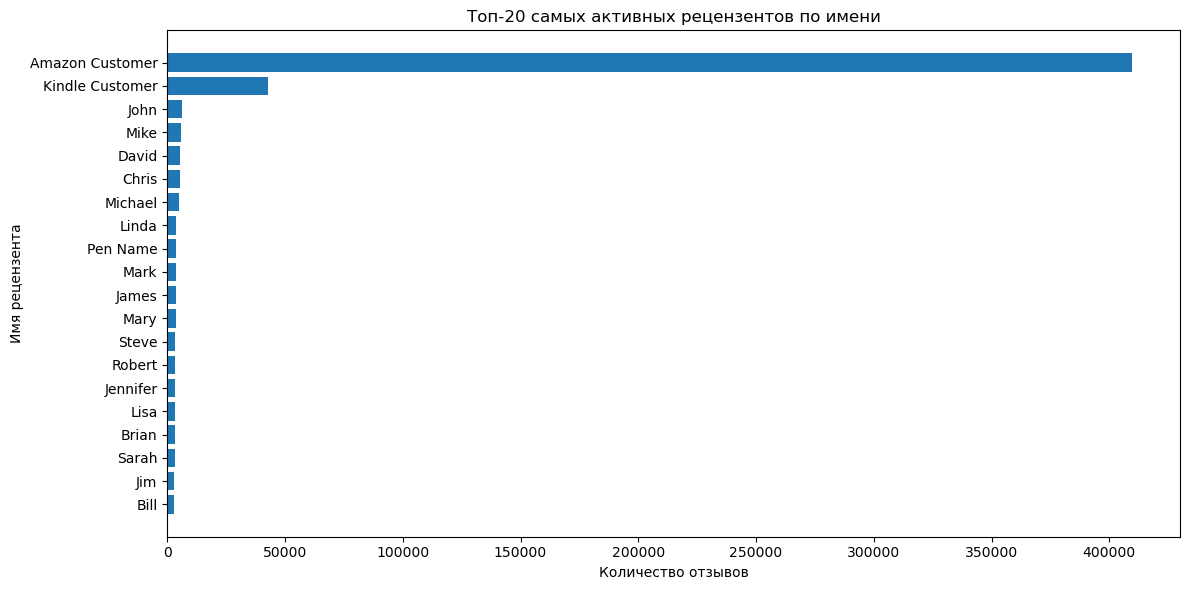


5. АНАЛИЗ ДЛИНЫ ИМЕН:
+-------+------------------+
|summary|       name_length|
+-------+------------------+
|  count|           6439543|
|   mean|10.591030450452774|
| stddev| 4.635204411419565|
|    min|                 1|
|    max|               100|
+-------+------------------+


6. РАСПРЕДЕЛЕНИЕ ДЛИНЫ ИМЕН:


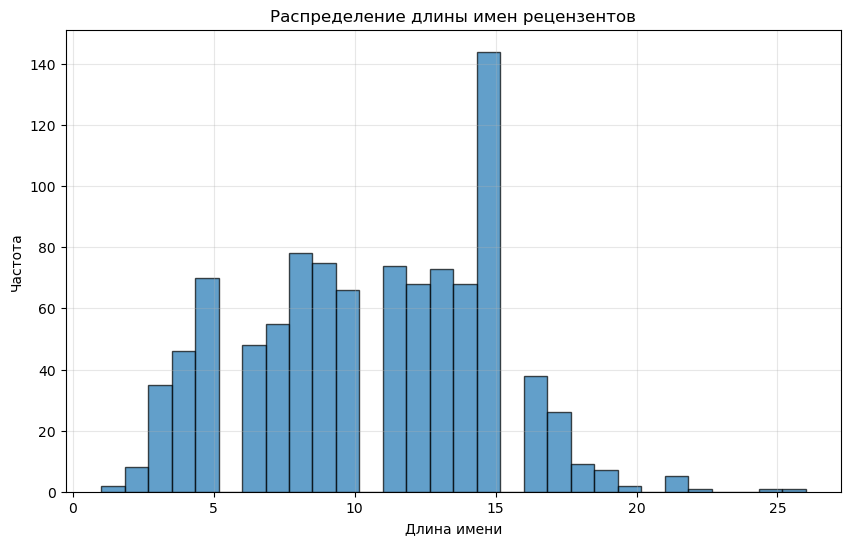


7. ПРИМЕРЫ ИМЕН РАЗНОЙ ДЛИНЫ:
Короткие имена (1-3 символа):
+------------+
|reviewerName|
+------------+
|         ...|
|         Cs.|
|           K|
|          LT|
|         PAW|
|          DZ|
|          MM|
|         BGM|
|         SCW|
|         DWR|
+------------+

Длинные имена (более 30 символов):
+--------------------+
|        reviewerName|
+--------------------+
|l.danford       g...|
|awesome good sour...|
|Peter Smith a.k.a...|
|Oreocokiemarshmal...|
|Charlensworthenhe...|
|Quality of Life M...|
|America the Beaut...|
|OKLAHOMA PANHANDL...|
|ozzaboo510. Chris...|
|The Humane Societ...|
+--------------------+


8. ПРОВЕРКА СПЕЦИАЛЬНЫХ СИМВОЛОВ:
Имен со специальными символами: 0


In [67]:
print("=== АНАЛИЗ СТОЛБЦА REVIEWERNAME ====")
print("reviewerName - имя рецензента (категориальный признак)")

# 1. Проверка уникальности и распределения
print("\n1. ПРОВЕРКА УНИКАЛЬНОСТИ:")
reviewername_unique_count = df_final.select("reviewerName").distinct().count()
print(f"Уникальных имен: {reviewername_unique_count}")
print(f"Соотношение уникальных имен к общему количеству: {reviewername_unique_count/total_rows*100:.2f}%")

# 2. Проверка на NULL и "Unknown" значения
print("\n2. ПРОВЕРКА NULL И 'UNKNOWN' ЗНАЧЕНИЙ:")
reviewername_null_count = df_final.filter(col("reviewerName").isNull()).count()
reviewername_unknown_count = df_final.filter(col("reviewerName") == "Unknown").count()
print(f"NULL значений: {reviewername_null_count}")
print(f"Значений 'Unknown': {reviewername_unknown_count}")
print(f"Процент 'Unknown': {reviewername_unknown_count/total_rows*100:.2f}%")

# 3. Топ самых популярных имен
print("\n3. ТОП-20 САМЫХ ПОПУЛЯРНЫХ ИМЕН:")
top_names = df_final.groupBy("reviewerName").count().orderBy(desc("count")).limit(20)
top_names.show()

# 4. Визуализация топ имен
print("\n4. ВИЗУАЛИЗАЦИЯ ТОП ИМЕН:")
top_names_pd = top_names.toPandas()

plt.figure(figsize=(12, 6))
plt.barh(top_names_pd["reviewerName"], top_names_pd["count"])
plt.xlabel("Количество отзывов")
plt.ylabel("Имя рецензента")
plt.title("Топ-20 самых активных рецензентов по имени")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5. Анализ длины имен
print("\n5. АНАЛИЗ ДЛИНЫ ИМЕН:")
df_final.withColumn("name_length", length("reviewerName")) \
       .select("name_length") \
       .describe() \
       .show()

# 6. Распределение длины имен
print("\n6. РАСПРЕДЕЛЕНИЕ ДЛИНЫ ИМЕН:")
name_length_stats = df_final.withColumn("name_length", length("reviewerName")) \
                           .select("name_length") \
                           .limit(1000) \
                           .toPandas()

plt.figure(figsize=(10, 6))
plt.hist(name_length_stats["name_length"], bins=30, edgecolor='black', alpha=0.7)
plt.title("Распределение длины имен рецензентов")
plt.xlabel("Длина имени")
plt.ylabel("Частота")
plt.grid(True, alpha=0.3)
plt.show()

# 7. Примеры имен разной длины
print("\n7. ПРИМЕРЫ ИМЕН РАЗНОЙ ДЛИНЫ:")
print("Короткие имена (1-3 символа):")
df_final.filter(length("reviewerName") <= 3).select("reviewerName").distinct().limit(10).show()

print("Длинные имена (более 30 символов):")
df_final.filter(length("reviewerName") > 30).select("reviewerName").distinct().limit(10).show()

# 8. Проверка специальных символов в именах
print("\n8. ПРОВЕРКА СПЕЦИАЛЬНЫХ СИМВОЛОВ:")
special_chars_count = df_final.filter(~col("reviewerName").rlike("^[a-zA-Z0-9\\s\\.\\-]+$")).count()
print(f"Имен со специальными символами: {special_chars_count}")

if special_chars_count > 0:
    print("Примеры имен со специальными символами:")
    df_final.filter(~col("reviewerName").rlike("^[a-zA-Z0-9\\s\\.\\-]+$")) \
           .select("reviewerName").distinct().limit(10).show()

### Анализ столбца `overall` (количественный признак - рейтинг)

=== АНАЛИЗ СТОЛБЦА OVERALL ====
overall - оценка продукта (количественный признак от 1.0 до 5.0)

1. БАЗОВАЯ СТАТИСТИКА:
+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|           6439543|
|   mean|4.2756305843442615|
| stddev|1.2005766460497826|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+


2. РАСПРЕДЕЛЕНИЕ ОЦЕНОК:
+-------+-------+
|overall|  count|
+-------+-------+
|    1.0| 446126|
|    2.0| 274155|
|    3.0| 498852|
|    4.0|1059935|
|    5.0|4160475|
+-------+-------+


3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ОЦЕНОК:


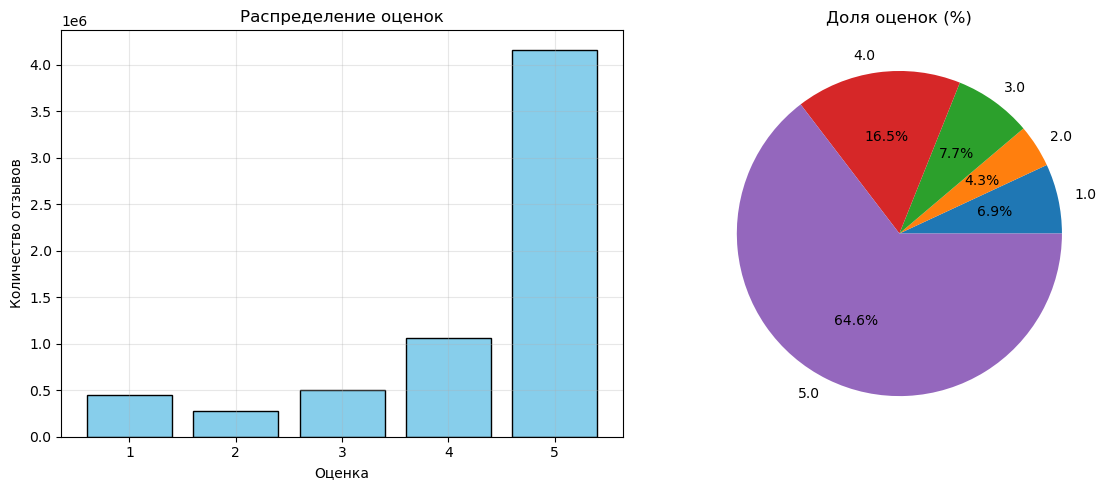


4. ПРОВЕРКА NULL ЗНАЧЕНИЙ:
NULL значений в overall: 0

5. ПРОВЕРКА ДИАПАЗОНА:
Оценок вне диапазона 1.0-5.0: 0

6. АНАЛИЗ ОКРУГЛЕНИЯ ОЦЕНОК:
+------------+-------+
|decimal_part|  count|
+------------+-------+
|         0.0|6439543|
+------------+-------+


7. BOXPLOT ОЦЕНОК:


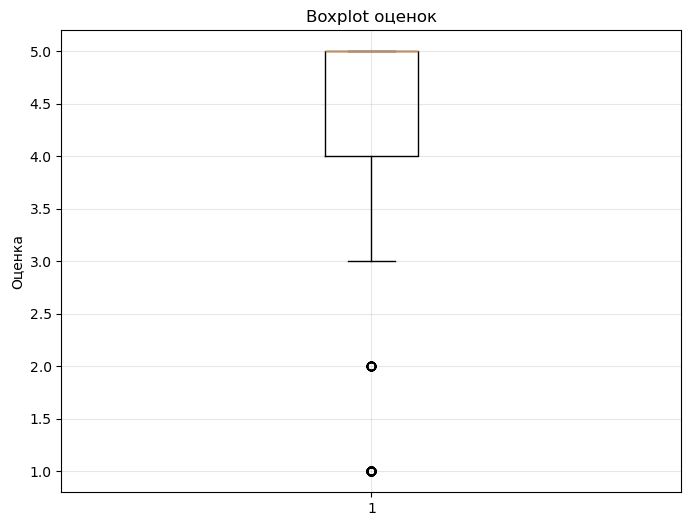


8. КАТЕГОРИЗАЦИЯ ОЦЕНОК:
+---------------+-------+
|rating_category|  count|
+---------------+-------+
|  Высокая (4-5)|5220410|
|   Низкая (1-3)| 720281|
|  Средняя (3-4)| 498852|
+---------------+-------+


9. СРЕДНЯЯ ОЦЕНКА ВО ВРЕМЕНИ:
Средняя оценка по годам:
+----------+------------------+------------+
|reviewYear|        avg_rating|review_count|
+----------+------------------+------------+
|      2000| 4.138527035878029|       27482|
|      2001| 4.098028646234407|       25972|
|      2002|  4.13124026559554|       24398|
|      2003| 4.107413386315659|       24159|
|      2004| 4.011574378534789|       30412|
|      2005| 4.018374470206931|       40110|
|      2006|4.1532226851535645|       43923|
|      2007| 4.297224663431534|       78513|
|      2008|4.2281708251935015|       80878|
|      2009| 4.199966673956738|       96021|
|      2010| 4.161906185600034|       93653|
|      2011|4.1610391500509385|      109936|
|      2012| 4.240254254891914|      216633|
|      2013| 4.

In [68]:
print("=== АНАЛИЗ СТОЛБЦА OVERALL ====")
print("overall - оценка продукта (количественный признак от 1.0 до 5.0)")

# 1. Базовая статистика
print("\n1. БАЗОВАЯ СТАТИСТИКА:")
df_final.select("overall").describe().show()

# 2. Распределение оценок
print("\n2. РАСПРЕДЕЛЕНИЕ ОЦЕНОК:")
rating_distribution = df_final.groupBy("overall").count().orderBy("overall")
rating_distribution.show()

# 3. Визуализация распределения оценок
print("\n3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ОЦЕНОК:")
rating_pd = rating_distribution.toPandas()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(rating_pd["overall"], rating_pd["count"], color='skyblue', edgecolor='black')
plt.xlabel("Оценка")
plt.ylabel("Количество отзывов")
plt.title("Распределение оценок")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(rating_pd["count"], labels=rating_pd["overall"], autopct='%1.1f%%')
plt.title("Доля оценок (%)")

plt.tight_layout()
plt.show()

# 4. Проверка на NULL значения
print("\n4. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
overall_null_count = df_final.filter(col("overall").isNull()).count()
print(f"NULL значений в overall: {overall_null_count}")

# 5. Проверка корректности диапазона
print("\n5. ПРОВЕРКА ДИАПАЗОНА:")
invalid_ratings = df_final.filter(~col("overall").between(1.0, 5.0))
print(f"Оценок вне диапазона 1.0-5.0: {invalid_ratings.count()}")

# 6. Анализ округления оценок
print("\n6. АНАЛИЗ ОКРУГЛЕНИЯ ОЦЕНОК:")
decimal_analysis = df_final.withColumn("decimal_part", col("overall") - floor(col("overall"))) \
                          .groupBy("decimal_part").count().orderBy("decimal_part")
decimal_analysis.show()

# 7. Boxplot для визуализации выбросов
print("\n7. BOXPLOT ОЦЕНОК:")
rating_sample = df_final.select("overall").sample(0.1).limit(1000).toPandas()

plt.figure(figsize=(8, 6))
plt.boxplot(rating_sample["overall"])
plt.title("Boxplot оценок")
plt.ylabel("Оценка")
plt.grid(True, alpha=0.3)
plt.show()

# 8. Анализ по категориям оценок
print("\n8. КАТЕГОРИЗАЦИЯ ОЦЕНОК:")
df_final.withColumn("rating_category", 
                   when(col("overall") >= 4.0, "Высокая (4-5)")
                   .when(col("overall") >= 3.0, "Средняя (3-4)")
                   .otherwise("Низкая (1-3)")) \
       .groupBy("rating_category").count() \
       .orderBy(desc("count")) \
       .show()

# 9. Средняя оценка по времени (если есть временные данные)
print("\n9. СРЕДНЯЯ ОЦЕНКА ВО ВРЕМЕНИ:")
try:
    df_with_year = df_final.withColumn("reviewYear", year("reviewTime"))
    yearly_ratings = df_with_year.groupBy("reviewYear").agg(
        mean("overall").alias("avg_rating"),
        count("*").alias("review_count")
    ).orderBy("reviewYear")
    
    print("Средняя оценка по годам:")
    yearly_ratings.show()
    
except Exception as e:
    print(f"Временной анализ невозможен: {e}")

### Анализ столбца `reviewText` (текстовый признак)

=== АНАЛИЗ СТОЛБЦА REVIEWTEXT ====
reviewText - текст отзыва (текстовый признак)

1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:
NULL значений: 0
Пустых значений: 0

2. АНАЛИЗ ДЛИНЫ ТЕКСТА ОТЗЫВОВ:
Статистика длины текста:
+-------+------------------+
|summary|       text_length|
+-------+------------------+
|  count|           6439543|
|   mean|155.52103511072136|
| stddev|204.24283990029096|
|    min|                10|
|    max|             30046|
+-------+------------------+


3. РАСПРЕДЕЛЕНИЕ ДЛИНЫ ТЕКСТА:


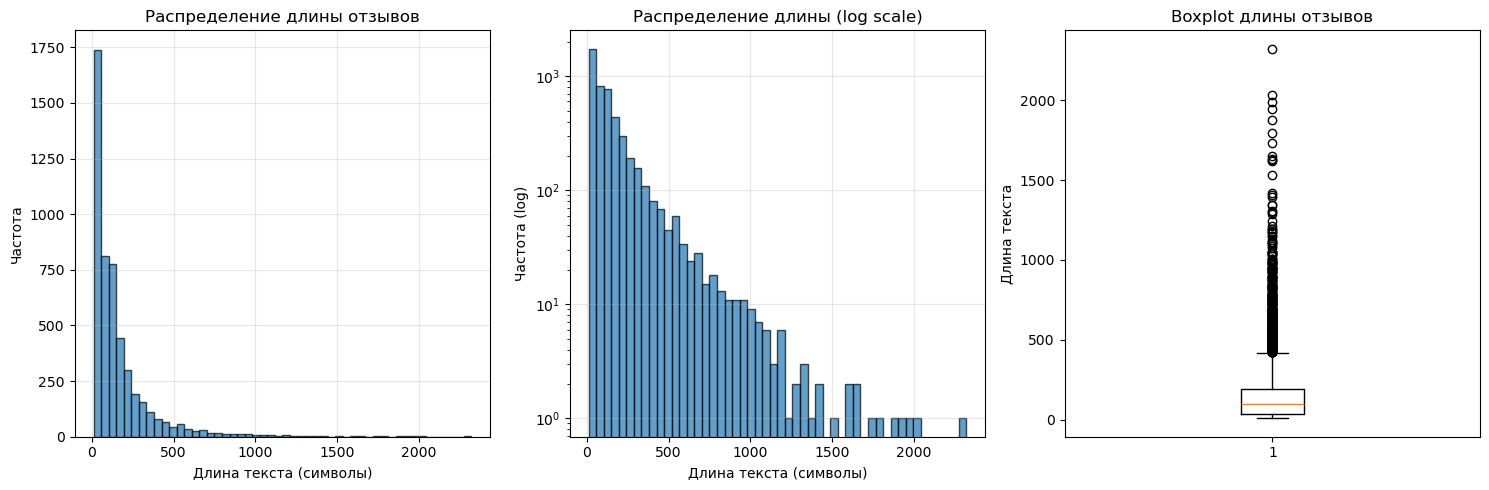


4. КОРРЕЛЯЦИЯ ДЛИНЫ ТЕКСТА И ОЦЕНКИ:
Корреляция между длиной текста и оценкой: -0.0870

5. СРЕДНЯЯ ДЛИНА ТЕКСТА ПО ОЦЕНКАМ:
+-------+------------------+-------+
|overall|        avg_length|  count|
+-------+------------------+-------+
|    1.0|188.08161371451115| 446126|
|    2.0|201.54574601958745| 274155|
|    3.0|184.90873645890966| 498852|
|    4.0| 166.9818885120314|1059935|
|    5.0|142.55330941779485|4160475|
+-------+------------------+-------+


6. ПРИМЕРЫ ОТЗЫВОВ РАЗНОЙ ДЛИНЫ:
Короткие отзывы (до 50 символов):
+-------------------------------------+-----------+
|reviewText                           |text_length|
+-------------------------------------+-----------+
|Wonderful. On time and great product.|37         |
|Movie was good.                      |15         |
|Great DVD.                           |10         |
|Good remake. Worth the watch         |28         |
|It's the best movie                  |19         |
+-------------------------------------+-----------+

Сред

In [71]:
print("=== АНАЛИЗ СТОЛБЦА REVIEWTEXT ====")
print("reviewText - текст отзыва (текстовый признак)")

# 1. Проверка на NULL значения
print("\n1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
reviewtext_null_count = df_final.filter(col("reviewText").isNull()).count()
reviewtext_empty_count = df_final.filter((col("reviewText").isNull()) | (col("reviewText") == "")).count()
print(f"NULL значений: {reviewtext_null_count}")
print(f"Пустых значений: {reviewtext_empty_count}")

# 2. Анализ длины текста отзывов
print("\n2. АНАЛИЗ ДЛИНЫ ТЕКСТА ОТЗЫВОВ:")
df_with_length = df_final.withColumn("text_length", length("reviewText"))

# Базовая статистика длины
print("Статистика длины текста:")
df_with_length.select("text_length").describe().show()

# 3. Визуализация распределения длины текста
print("\n3. РАСПРЕДЕЛЕНИЕ ДЛИНЫ ТЕКСТА:")
length_sample = df_with_length.select("text_length").sample(0.1).limit(5000).toPandas()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(length_sample["text_length"], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Длина текста (символы)")
plt.ylabel("Частота")
plt.title("Распределение длины отзывов")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
# Логарифмическая шкала для лучшей визуализации
plt.hist(length_sample["text_length"], bins=50, edgecolor='black', alpha=0.7, log=True)
plt.xlabel("Длина текста (символы)")
plt.ylabel("Частота (log)")
plt.title("Распределение длины (log scale)")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.boxplot(length_sample["text_length"])
plt.ylabel("Длина текста")
plt.title("Boxplot длины отзывов")

plt.tight_layout()
plt.show()

# 4. Корреляция длины текста с оценкой
print("\n4. КОРРЕЛЯЦИЯ ДЛИНЫ ТЕКСТА И ОЦЕНКИ:")
correlation = df_with_length.select(corr("text_length", "overall")).collect()[0][0]
print(f"Корреляция между длиной текста и оценкой: {correlation:.4f}")

# 5. Средняя длина текста по оценкам
print("\n5. СРЕДНЯЯ ДЛИНА ТЕКСТА ПО ОЦЕНКАМ:")
length_by_rating = df_with_length.groupBy("overall").agg(
    mean("text_length").alias("avg_length"),
    count("*").alias("count")
).orderBy("overall")
length_by_rating.show()

# 6. Примеры отзывов разной длины
print("\n6. ПРИМЕРЫ ОТЗЫВОВ РАЗНОЙ ДЛИНЫ:")
print("Короткие отзывы (до 50 символов):")
df_with_length.filter(col("text_length") <= 50).select("reviewText", "text_length").limit(5).show(truncate=False)

print("Средние отзывы (100-200 символов):")
df_with_length.filter((col("text_length") >= 100) & (col("text_length") <= 200)).select("reviewText", "text_length").limit(3).show(truncate=False)

print("Длинные отзывы (более 1000 символов):")
df_with_length.filter(col("text_length") > 1000).select("reviewText", "text_length").limit(2).show(truncate=False)

# 7. Анализ выбросов по длине
print("\n7. АНАЛИЗ ВЫБРОСОВ ПО ДЛИНЕ:")
very_long_reviews = df_with_length.filter(col("text_length") > 5000)
print(f"Отзывов длиннее 5000 символов: {very_long_reviews.count()}")

very_short_reviews = df_with_length.filter(col("text_length") < 10)
print(f"Отзывов короче 10 символов: {very_short_reviews.count()}")

# 8. Распределение длины текста по категориям оценок
print("\n8. РАСПРЕДЕЛЕНИЕ ДЛИНЫ ПО КАТЕГОРИЯМ ОЦЕНОК:")
df_with_categories = df_with_length.withColumn("rating_category", 
                   when(col("overall") >= 4.0, "Высокая")
                   .when(col("overall") >= 3.0, "Средняя")
                   .otherwise("Низкая"))

category_length_stats = df_with_categories.groupBy("rating_category").agg(
    mean("text_length").alias("avg_length"),
    stddev("text_length").alias("std_length"),
    count("*").alias("count")
).orderBy("avg_length")
category_length_stats.show()

### Анализ столбца `summary` (текстовый признак)

=== АНАЛИЗ СТОЛБЦА SUMMARY ====
summary - краткое описание отзыва (текстовый признак)

1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:
NULL значений: 0
Пустых значений: 0

2. АНАЛИЗ ДЛИНЫ SUMMARY:
Статистика длины summary:
+-------+-----------------+
|summary|   summary_length|
+-------+-----------------+
|  count|          6439543|
|   mean|20.64180579274026|
| stddev|17.14123291544707|
|    min|                1|
|    max|             1139|
+-------+-----------------+


3. РАСПРЕДЕЛЕНИЕ ДЛИНЫ SUMMARY:


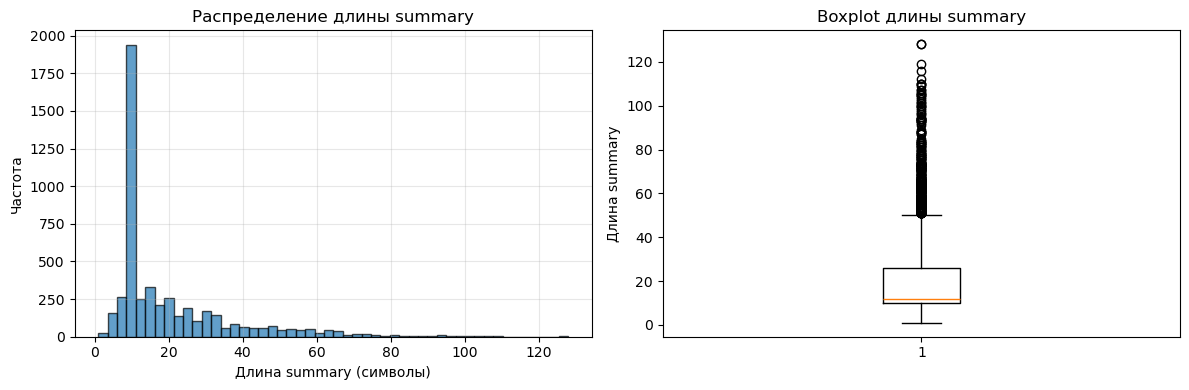


4. ТОП-20 САМЫХ ПОПУЛЯРНЫХ SUMMARY:
+------------+-------+
|summary     |count  |
+------------+-------+
|Five Stars  |1424714|
|Four Stars  |334050 |
|Three Stars |139033 |
|One Star    |110443 |
|Two Stars   |69660  |
|Great movie |24245  |
|Great Movie |16974  |
|Great       |16593  |
|Good movie  |13421  |
|Awesome     |11725  |
|Great movie!|10989  |
|Excellent   |10845  |
|Love it!    |9735   |
|Love it     |8867   |
|great movie |8474   |
|Great!      |7776   |
|Good        |7348   |
|great       |7078   |
|Good Movie  |6911   |
|Loved it!   |6533   |
+------------+-------+


5. ВИЗУАЛИЗАЦИЯ ТОП SUMMARY:


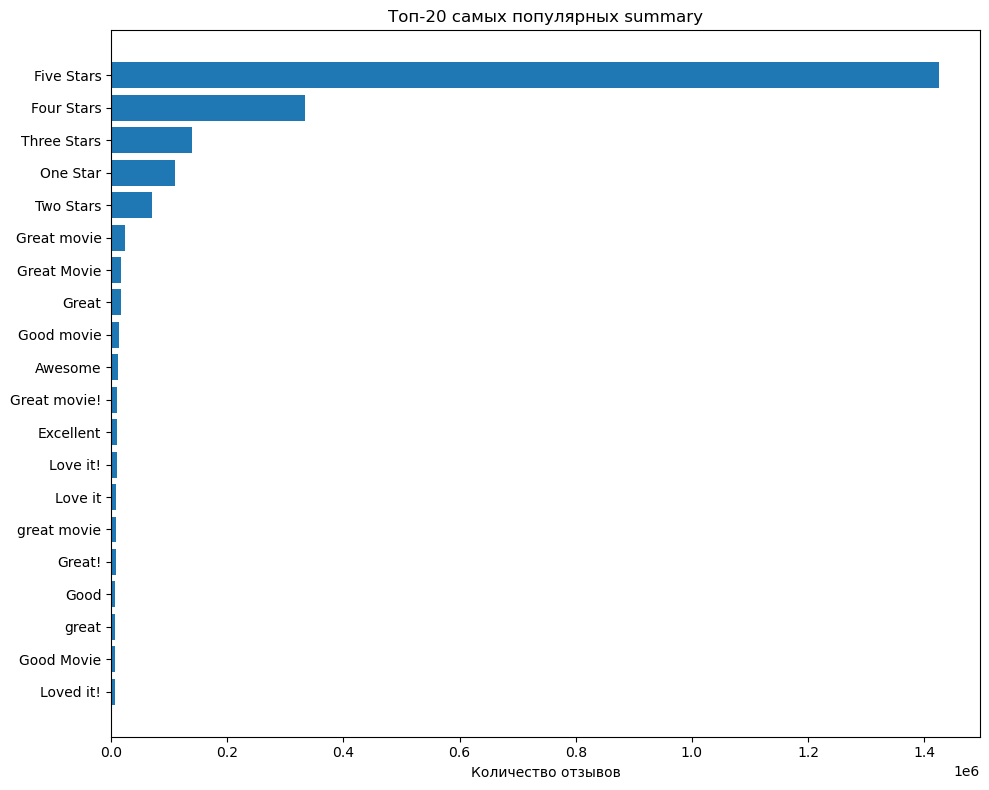


6. КОРРЕЛЯЦИЯ ДЛИНЫ SUMMARY И ОЦЕНКИ:
Корреляция между длиной summary и оценкой: -0.0653

7. СРЕДНЯЯ ДЛИНА SUMMARY ПО ОЦЕНКАМ:
+-------+------------------+-------+
|overall|        avg_length|  count|
+-------+------------------+-------+
|    1.0|22.629172027633448| 446126|
|    2.0|23.106111506264703| 274155|
|    3.0|23.084626301989367| 498852|
|    4.0|21.243757400217937|1059935|
|    5.0|19.820059969114105|4160475|
+-------+------------------+-------+


8. ПРИМЕРЫ SUMMARY РАЗНОЙ ДЛИНЫ:
Короткие summary (до 10 символов):
+----------+--------------+
|summary   |summary_length|
+----------+--------------+
|Five Stars|10            |
|Great!    |6             |
|Five Stars|10            |
|Five Stars|10            |
|Deadzone  |8             |
+----------+--------------+

Средние summary (20-40 символов):
+-------------------------------------+--------------+
|summary                              |summary_length|
+-------------------------------------+--------------+
|I love watching 

In [72]:
print("=== АНАЛИЗ СТОЛБЦА SUMMARY ====")
print("summary - краткое описание отзыва (текстовый признак)")

# 1. Проверка на NULL значения
print("\n1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
summary_null_count = df_final.filter(col("summary").isNull()).count()
summary_empty_count = df_final.filter((col("summary").isNull()) | (col("summary") == "")).count()
print(f"NULL значений: {summary_null_count}")
print(f"Пустых значений: {summary_empty_count}")

# 2. Анализ длины summary
print("\n2. АНАЛИЗ ДЛИНЫ SUMMARY:")
df_with_summary_length = df_final.withColumn("summary_length", length("summary"))

# Базовая статистика длины
print("Статистика длины summary:")
df_with_summary_length.select("summary_length").describe().show()

# 3. Визуализация распределения длины summary
print("\n3. РАСПРЕДЕЛЕНИЕ ДЛИНЫ SUMMARY:")
summary_length_sample = df_with_summary_length.select("summary_length").sample(0.1).limit(5000).toPandas()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(summary_length_sample["summary_length"], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Длина summary (символы)")
plt.ylabel("Частота")
plt.title("Распределение длины summary")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(summary_length_sample["summary_length"])
plt.ylabel("Длина summary")
plt.title("Boxplot длины summary")

plt.tight_layout()
plt.show()

# 4. Топ самых популярных summary
print("\n4. ТОП-20 САМЫХ ПОПУЛЯРНЫХ SUMMARY:")
top_summaries = df_final.groupBy("summary").count().orderBy(desc("count")).limit(20)
top_summaries.show(truncate=False)

# 5. Визуализация топ summary
print("\n5. ВИЗУАЛИЗАЦИЯ ТОП SUMMARY:")
top_summaries_pd = top_summaries.toPandas()

plt.figure(figsize=(10, 8))
plt.barh(top_summaries_pd["summary"], top_summaries_pd["count"])
plt.xlabel("Количество отзывов")
plt.title("Топ-20 самых популярных summary")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6. Корреляция длины summary с оценкой
print("\n6. КОРРЕЛЯЦИЯ ДЛИНЫ SUMMARY И ОЦЕНКИ:")
correlation_summary = df_with_summary_length.select(corr("summary_length", "overall")).collect()[0][0]
print(f"Корреляция между длиной summary и оценкой: {correlation_summary:.4f}")

# 7. Средняя длина summary по оценкам
print("\n7. СРЕДНЯЯ ДЛИНА SUMMARY ПО ОЦЕНКАМ:")
summary_length_by_rating = df_with_summary_length.groupBy("overall").agg(
    mean("summary_length").alias("avg_length"),
    count("*").alias("count")
).orderBy("overall")
summary_length_by_rating.show()

# 8. Примеры summary разной длины
print("\n8. ПРИМЕРЫ SUMMARY РАЗНОЙ ДЛИНЫ:")
print("Короткие summary (до 10 символов):")
df_with_summary_length.filter(col("summary_length") <= 10).select("summary", "summary_length").limit(5).show(truncate=False)

print("Средние summary (20-40 символов):")
df_with_summary_length.filter((col("summary_length") >= 20) & (col("summary_length") <= 40)).select("summary", "summary_length").limit(3).show(truncate=False)

print("Длинные summary (более 100 символов):")
df_with_summary_length.filter(col("summary_length") > 100).select("summary", "summary_length").limit(2).show(truncate=False)

# 9. Анализ уникальности summary
print("\n9. АНАЛИЗ УНИКАЛЬНОСТИ SUMMARY:")
summary_unique_count = df_final.select("summary").distinct().count()
print(f"Уникальных summary: {summary_unique_count}")
print(f"Соотношение уникальных summary к общему количеству: {summary_unique_count/total_rows*100:.2f}%")

### Анализ столбца `unixReviewTime` (временной признак)

=== АНАЛИЗ СТОЛБЦА UNIXREVIEWTIME ====
unixReviewTime - временная метка отзыва (временной признак)

1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:
NULL значений в unixReviewTime: 0

2. БАЗОВАЯ СТАТИСТИКА:
+-------+--------------------+
|summary|      unixReviewTime|
+-------+--------------------+
|  count|             6439543|
|   mean|1.4104084789614418E9|
| stddev| 9.114636196261744E7|
|    min|           946684800|
|    max|          1538524800|
+-------+--------------------+


3. ПРЕОБРАЗОВАНИЕ В ДАТУ И АНАЛИЗ РАСПРЕДЕЛЕНИЯ:
Распределение отзывов по годам:
+-----------+-------+
|review_year|  count|
+-----------+-------+
|       2000|  27482|
|       2001|  25972|
|       2002|  24398|
|       2003|  24159|
|       2004|  30412|
|       2005|  40110|
|       2006|  43923|
|       2007|  78513|
|       2008|  80878|
|       2009|  96021|
|       2010|  93653|
|       2011| 109936|
|       2012| 216633|
|       2013| 687180|
|       2014|1118033|
|       2015|1429621|
|       2016|1542052|
|       2017|

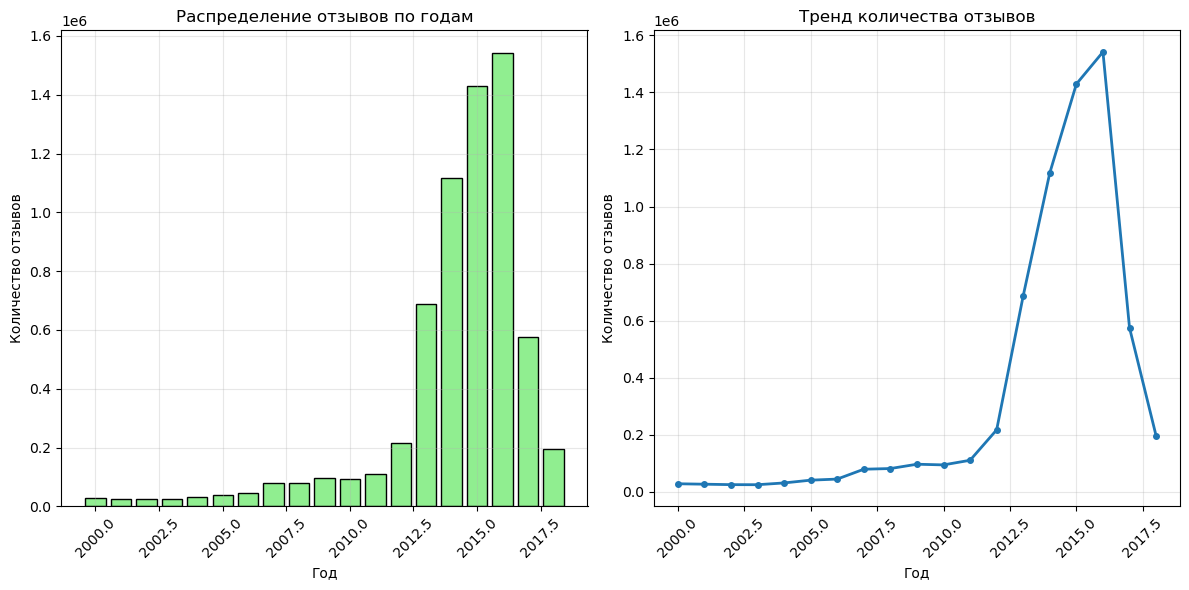


5. АНАЛИЗ СЕЗОННОСТИ ПО МЕСЯЦАМ:
Распределение по месяцам:
+------------+------+
|review_month| count|
+------------+------+
|           1|693148|
|           2|574936|
|           3|597269|
|           4|480094|
|           5|510991|
|           6|497360|
|           7|532490|
|           8|515077|
|           9|508885|
|          10|491145|
|          11|455907|
|          12|582241|
+------------+------+



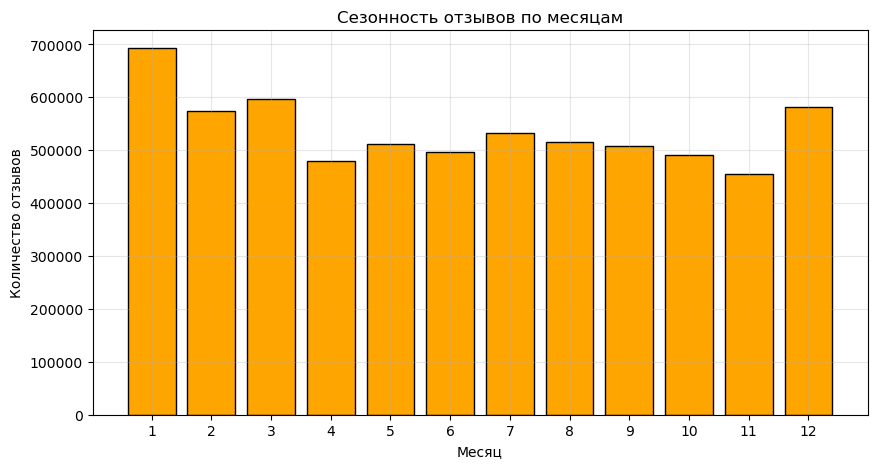


6. ПРОВЕРКА КОРРЕКТНОСТИ ВРЕМЕННЫХ МЕТОК:
Минимальная временная метка: 946684800 (2000-01-01 00:00:00)
Максимальная временная метка: 1538524800 (2018-10-03 00:00:00)
Отзывов до 2000 года: 0
Отзывов после 2020 года: 0

7. BOXPLOT ВРЕМЕННЫХ МЕТОК:


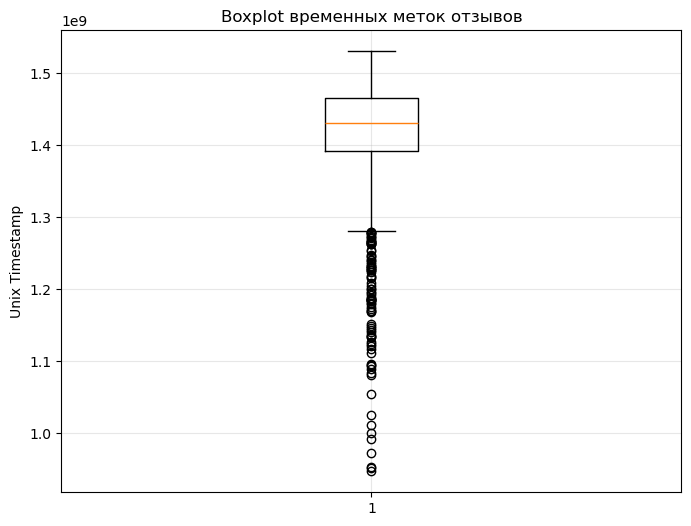


8. СРЕДНЯЯ ОЦЕНКА ПО ГОДАМ:
Средняя оценка по годам:
+-----------+------------------+------------+
|review_year|        avg_rating|review_count|
+-----------+------------------+------------+
|       2000| 4.138527035878029|       27482|
|       2001| 4.098028646234407|       25972|
|       2002|  4.13124026559554|       24398|
|       2003| 4.107413386315659|       24159|
|       2004| 4.011574378534789|       30412|
|       2005| 4.018374470206931|       40110|
|       2006|4.1532226851535645|       43923|
|       2007| 4.297224663431534|       78513|
|       2008|4.2281708251935015|       80878|
|       2009| 4.199966673956738|       96021|
|       2010| 4.161906185600034|       93653|
|       2011|4.1610391500509385|      109936|
|       2012| 4.240254254891914|      216633|
|       2013| 4.321420879536657|      687180|
|       2014|4.3129496177662014|     1118033|
|       2015| 4.280861850798218|     1429621|
|       2016|  4.26524137966813|     1542052|
|       2017| 4.2969550788

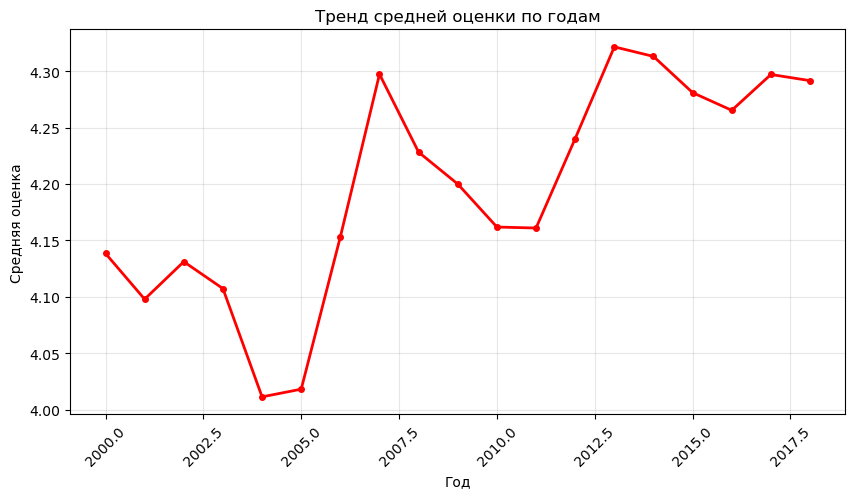

In [76]:
from pyspark.sql.functions import min, max

print("=== АНАЛИЗ СТОЛБЦА UNIXREVIEWTIME ====")
print("unixReviewTime - временная метка отзыва (временной признак)")

# 1. Проверка на NULL значения
print("\n1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
unix_null_count = df_final.filter(col("unixReviewTime").isNull()).count()
print(f"NULL значений в unixReviewTime: {unix_null_count}")

# 2. Базовая статистика
print("\n2. БАЗОВАЯ СТАТИСТИКА:")
df_final.select("unixReviewTime").describe().show()

# 3. Преобразование в читаемую дату и анализ распределения
print("\n3. ПРЕОБРАЗОВАНИЕ В ДАТУ И АНАЛИЗ РАСПРЕДЕЛЕНИЯ:")
df_with_dates = df_final.withColumn("review_date", from_unixtime("unixReviewTime")) \
                       .withColumn("review_year", year("review_date")) \
                       .withColumn("review_month", month("review_date")) \
                       .withColumn("review_day", dayofmonth("review_date"))

# Анализ по годам
print("Распределение отзывов по годам:")
yearly_distribution = df_with_dates.groupBy("review_year").count().orderBy("review_year")
yearly_distribution.show()

# 4. Визуализация распределения по годам
print("\n4. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ПО ГОДАМ:")
yearly_pd = yearly_distribution.toPandas()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(yearly_pd["review_year"], yearly_pd["count"], color='lightgreen', edgecolor='black')
plt.xlabel("Год")
plt.ylabel("Количество отзывов")
plt.title("Распределение отзывов по годам")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(yearly_pd["review_year"], yearly_pd["count"], marker='o', linewidth=2, markersize=4)
plt.xlabel("Год")
plt.ylabel("Количество отзывов")
plt.title("Тренд количества отзывов")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Анализ по месяцам (сезонность)
print("\n5. АНАЛИЗ СЕЗОННОСТИ ПО МЕСЯЦАМ:")
monthly_distribution = df_with_dates.groupBy("review_month").count().orderBy("review_month")
print("Распределение по месяцам:")
monthly_distribution.show()

# Визуализация сезонности
monthly_pd = monthly_distribution.toPandas()
plt.figure(figsize=(10, 5))
plt.bar(monthly_pd["review_month"], monthly_pd["count"], color='orange', edgecolor='black')
plt.xlabel("Месяц")
plt.ylabel("Количество отзывов")
plt.title("Сезонность отзывов по месяцам")
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.show()

# 6. Проверка корректности временных меток
print("\n6. ПРОВЕРКА КОРРЕКТНОСТИ ВРЕМЕННЫХ МЕТОК:")
min_timestamp = df_final.agg(min("unixReviewTime")).collect()[0][0]
max_timestamp = df_final.agg(max("unixReviewTime")).collect()[0][0]

# Для преобразования timestamp в дату используем отдельный запрос
min_date = df_final.select(from_unixtime(min("unixReviewTime")).alias("min_date")).collect()[0][0]
max_date = df_final.select(from_unixtime(max("unixReviewTime")).alias("max_date")).collect()[0][0]

print(f"Минимальная временная метка: {min_timestamp} ({min_date})")
print(f"Максимальная временная метка: {max_timestamp} ({max_date})")

# Проверка на выбросы (до 2000 года или будущее время)
outdated_reviews = df_final.filter(col("unixReviewTime") < 946684800)  # до 2000-01-01
future_reviews = df_final.filter(col("unixReviewTime") > 1577836800)   # после 2020-01-01
print(f"Отзывов до 2000 года: {outdated_reviews.count()}")
print(f"Отзывов после 2020 года: {future_reviews.count()}")

# 7. Boxplot временных меток для визуализации выбросов
print("\n7. BOXPLOT ВРЕМЕННЫХ МЕТОК:")
timestamp_sample = df_final.select("unixReviewTime").sample(0.1).limit(1000).toPandas()

plt.figure(figsize=(8, 6))
plt.boxplot(timestamp_sample["unixReviewTime"])
plt.ylabel("Unix Timestamp")
plt.title("Boxplot временных меток отзывов")
plt.grid(True, alpha=0.3)
plt.show()

# 8. Анализ средней оценки по годам
print("\n8. СРЕДНЯЯ ОЦЕНКА ПО ГОДАМ:")
yearly_ratings = df_with_dates.groupBy("review_year").agg(
    mean("overall").alias("avg_rating"),
    count("*").alias("review_count")
).orderBy("review_year")

print("Средняя оценка по годам:")
yearly_ratings.show()

# Визуализация тренда оценок
yearly_ratings_pd = yearly_ratings.toPandas()
plt.figure(figsize=(10, 5))
plt.plot(yearly_ratings_pd["review_year"], yearly_ratings_pd["avg_rating"], 
         marker='o', linewidth=2, markersize=4, color='red')
plt.xlabel("Год")
plt.ylabel("Средняя оценка")
plt.title("Тренд средней оценки по годам")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

### Анализ столбца `reviewTime` (временной признак)

=== АНАЛИЗ СТОЛБЦА REVIEWTIME ====
reviewTime - дата отзыва в формате YYYY-MM-DD (временной признак)

1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:
NULL значений в reviewTime: 0

2. ПРОВЕРКА СОГЛАСОВАННОСТИ С UNIXREVIEWTIME:
Несоответствий между reviewTime и unixReviewTime: 2356632
Примеры несоответствий:
+----------+---------------------+--------------+
|reviewTime|calculated_reviewTime|unixReviewTime|
+----------+---------------------+--------------+
|2017-04-06|           2017-06-04|    1496534400|
|2014-10-07|           2014-07-10|    1404950400|
|2014-07-03|           2014-03-07|    1394150400|
|2015-11-08|           2015-08-11|    1439251200|
|2013-01-07|           2013-07-01|    1372636800|
+----------+---------------------+--------------+


3. АНАЛИЗ ФОРМАТА ДАТЫ:
Примеры значений reviewTime:
+----------+
|reviewTime|
+----------+
|2014-12-13|
|2016-08-17|
|2015-05-01|
|2008-11-19|
|2017-12-05|
|2009-01-04|
|2009-12-04|
|2002-05-13|
|2013-03-14|
|2017-05-14|
+----------+

Некорректных форматов да

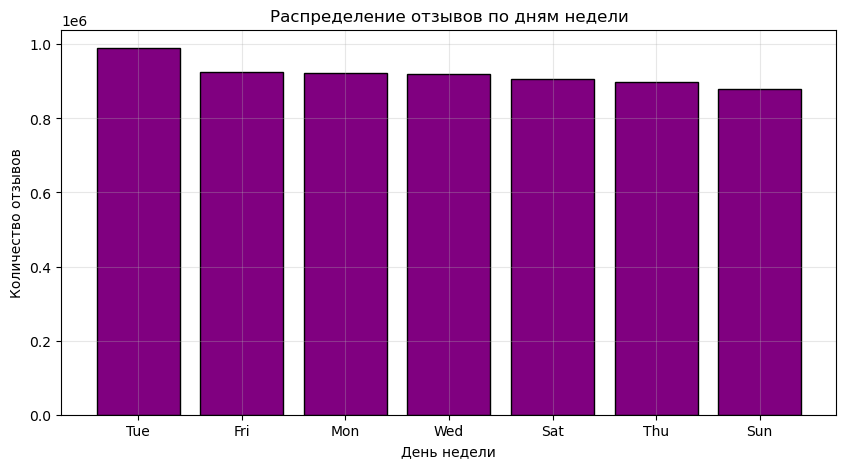


5. ТОП-10 САМЫХ АКТИВНЫХ ДНЕЙ:
Самые активные дни по количеству отзывов:
+-----------+-----+
|review_date|count|
+-----------+-----+
| 2016-03-29|24423|
| 2015-02-20|23889|
| 2016-02-16|20834|
| 2016-04-19|19874|
| 2016-07-15|18054|
| 2015-07-10|17153|
| 2016-09-08|16511|
| 2016-01-23|15617|
| 2015-02-28|14771|
| 2015-09-25|14649|
+-----------+-----+


6. ВРЕМЕННОЙ ДИАПАЗОН:
Минимальная дата: 2000-01-01
Максимальная дата: 2018-12-09
Период данных: 6917 дней

7. ПЛОТНОСТЬ ОТЗЫВОВ ВО ВРЕМЕНИ:
Плотность отзывов по месяцам (первые 20):
+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2000|    1| 2558|
|2000|    2| 2331|
|2000|    3| 2693|
|2000|    4| 2550|
|2000|    5| 2278|
|2000|    6| 2791|
|2000|    7| 2300|
|2000|    8| 2115|
|2000|    9| 1936|
|2000|   10| 1879|
|2000|   11| 1810|
|2000|   12| 2241|
|2001|    1| 1925|
|2001|    2| 2010|
|2001|    3| 2020|
|2001|    4| 1871|
|2001|    5| 2283|
|2001|    6| 2405|
|2001|    7| 2533|
|2001|    8| 2643|
+----+-----+-----+


8. 

In [82]:
print("=== АНАЛИЗ СТОЛБЦА REVIEWTIME ====")
print("reviewTime - дата отзыва в формате YYYY-MM-DD (временной признак)")

# 1. Проверка на NULL значения
print("\n1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
reviewtime_null_count = df_final.filter(col("reviewTime").isNull()).count()
print(f"NULL значений в reviewTime: {reviewtime_null_count}")

# 2. Проверка согласованности с unixReviewTime
print("\n2. ПРОВЕРКА СОГЛАСОВАННОСТИ С UNIXREVIEWTIME:")
# Создаем reviewTime из unixReviewTime для сравнения
df_comparison = df_final.withColumn("calculated_reviewTime", from_unixtime("unixReviewTime", "yyyy-MM-dd"))

# Сравниваем исходный reviewTime с рассчитанным из unixReviewTime
mismatch_count = df_comparison.filter(col("reviewTime") != col("calculated_reviewTime")).count()
print(f"Несоответствий между reviewTime и unixReviewTime: {mismatch_count}")

if mismatch_count > 0:
    print("Примеры несоответствий:")
    df_comparison.filter(col("reviewTime") != col("calculated_reviewTime")) \
                .select("reviewTime", "calculated_reviewTime", "unixReviewTime").limit(5).show()

# 3. Анализ формата даты
print("\n3. АНАЛИЗ ФОРМАТА ДАТЫ:")
print("Примеры значений reviewTime:")
df_final.select("reviewTime").distinct().limit(10).show()

# Проверка корректности формата даты
invalid_dates = df_final.filter(~col("reviewTime").rlike(r"^\d{4}-\d{2}-\d{2}$"))
print(f"Некорректных форматов даты: {invalid_dates.count()}")

# 4. Анализ распределения по дням недели
print("\n4. АНАЛИЗ ПО ДНЯМ НЕДЕЛИ:")
df_with_weekday = df_final.withColumn("review_date", to_date("reviewTime", "yyyy-MM-dd")) \
                         .withColumn("day_of_week", date_format("review_date", "E"))

weekday_distribution = df_with_weekday.groupBy("day_of_week").count().orderBy("count", ascending=False)
print("Распределение отзывов по дням недели:")
weekday_distribution.show()

# Визуализация дней недели
weekday_pd = weekday_distribution.toPandas()
plt.figure(figsize=(10, 5))
plt.bar(weekday_pd["day_of_week"], weekday_pd["count"], color='purple', edgecolor='black')
plt.xlabel("День недели")
plt.ylabel("Количество отзывов")
plt.title("Распределение отзывов по дням недели")
plt.grid(True, alpha=0.3)
plt.show()

# 5. Анализ самых активных дней
print("\n5. ТОП-10 САМЫХ АКТИВНЫХ ДНЕЙ:")
daily_activity = df_with_weekday.groupBy("review_date").count().orderBy(desc("count")).limit(10)
print("Самые активные дни по количеству отзывов:")
daily_activity.show()

# 6. Анализ временного диапазона
print("\n6. ВРЕМЕННОЙ ДИАПАЗОН:")
min_date = df_final.agg(min("reviewTime")).collect()[0][0]
max_date = df_final.agg(max("reviewTime")).collect()[0][0]
print(f"Минимальная дата: {min_date}")
print(f"Максимальная дата: {max_date}")

# Расчет общего периода в днях
from datetime import datetime
min_dt = datetime.strptime(min_date, "%Y-%m-%d")
max_dt = datetime.strptime(max_date, "%Y-%m-%d")
days_span = (max_dt - min_dt).days
print(f"Период данных: {days_span} дней")

# 7. Плотность отзывов во времени
print("\n7. ПЛОТНОСТЬ ОТЗЫВОВ ВО ВРЕМЕНИ:")
# Группировка по месяцам для анализа плотности
monthly_density = df_with_weekday.groupBy(
    year("review_date").alias("year"),
    month("review_date").alias("month")
).count().orderBy("year", "month")

print("Плотность отзывов по месяцам (первые 20):")
monthly_density.limit(20).show()

# 8. Анализ качества данных
print("\n8. КАЧЕСТВО ДАННЫХ REVIEWTIME:")
# Проверка на будущие даты
future_dates = df_final.filter(col("reviewTime") > "2024-12-31")
print(f"Даты из будущего: {future_dates.count()}")

# Проверка на слишком старые даты
ancient_dates = df_final.filter(col("reviewTime") < "2000-01-01")
print(f"Даты до 2000 года: {ancient_dates.count()}")

# 9. Сводка по временным данным
print("\n9. СВОДКА ПО ВРЕМЕННЫМ ДАННЫМ:")
print(f"Общий период: с {min_date} по {max_date}")
print(f"Всего дней в данных: {days_span}")
print(f"Среднее количество отзывов в день: {df_final.count() / days_span:.1f}")
print(f"Дней с отзывами: {df_with_weekday.select('review_date').distinct().count()}")

### Итоговый анализ и корреляции 

=== ИТОГОВЫЙ АНАЛИЗ ДАННЫХ ===
=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ И ВЫВОДЫ ===

1. ПОДГОТОВКА ДАННЫХ ДЛЯ КОРРЕЛЯЦИОННОГО АНАЛИЗА:

2. КОРРЕЛЯЦИОННАЯ МАТРИЦА ЧИСЛОВЫХ ПРИЗНАКОВ:


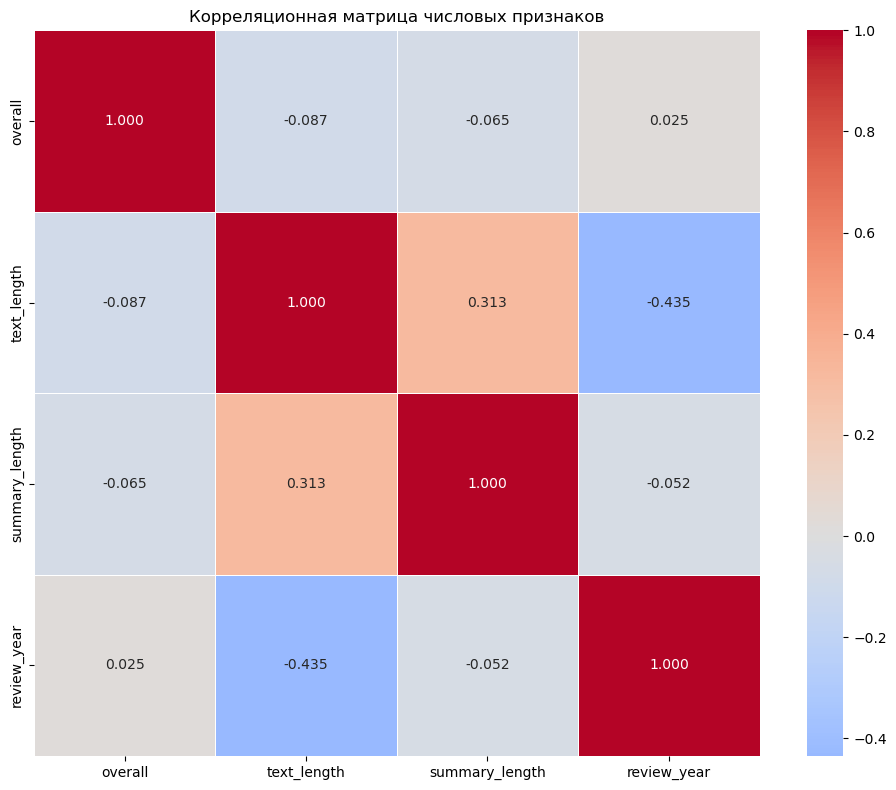


3. АНАЛИЗ КЛЮЧЕВЫХ КОРРЕЛЯЦИЙ:
Наиболее значимые корреляции:
text_length ↔ review_year: -0.4349 (отрицательная)
text_length ↔ summary_length: 0.3126 (положительная)
overall ↔ text_length: -0.0870 (отрицательная)
overall ↔ summary_length: -0.0653 (отрицательная)
summary_length ↔ review_year: -0.0518 (отрицательная)

4. ИТОГОВАЯ СТАТИСТИКА ПО ВСЕМ СТОЛБЦАМ:
Общее количество отзывов: 6,439,543
Период данных: 2000-2018 (19 лет)
Уникальных продуктов: 161,908
Уникальных рецензентов: 3,210,466

5. ОЦЕНКА КАЧЕСТВА ДАННЫХ:
Проблемы качества данных:
  NULL в ключевых полях: 0 (0.0000%)
  Некорректные ASIN: 0 (0.0000%)
  Некорректные оценки: 0 (0.0000%)
  Некорректные даты: 0 (0.0000%)
  Дубликаты отзывов: 3617 (0.0562%)

6. ВИЗУАЛИЗАЦИЯ КЛЮЧЕВЫХ ПОКАЗАТЕЛЕЙ:


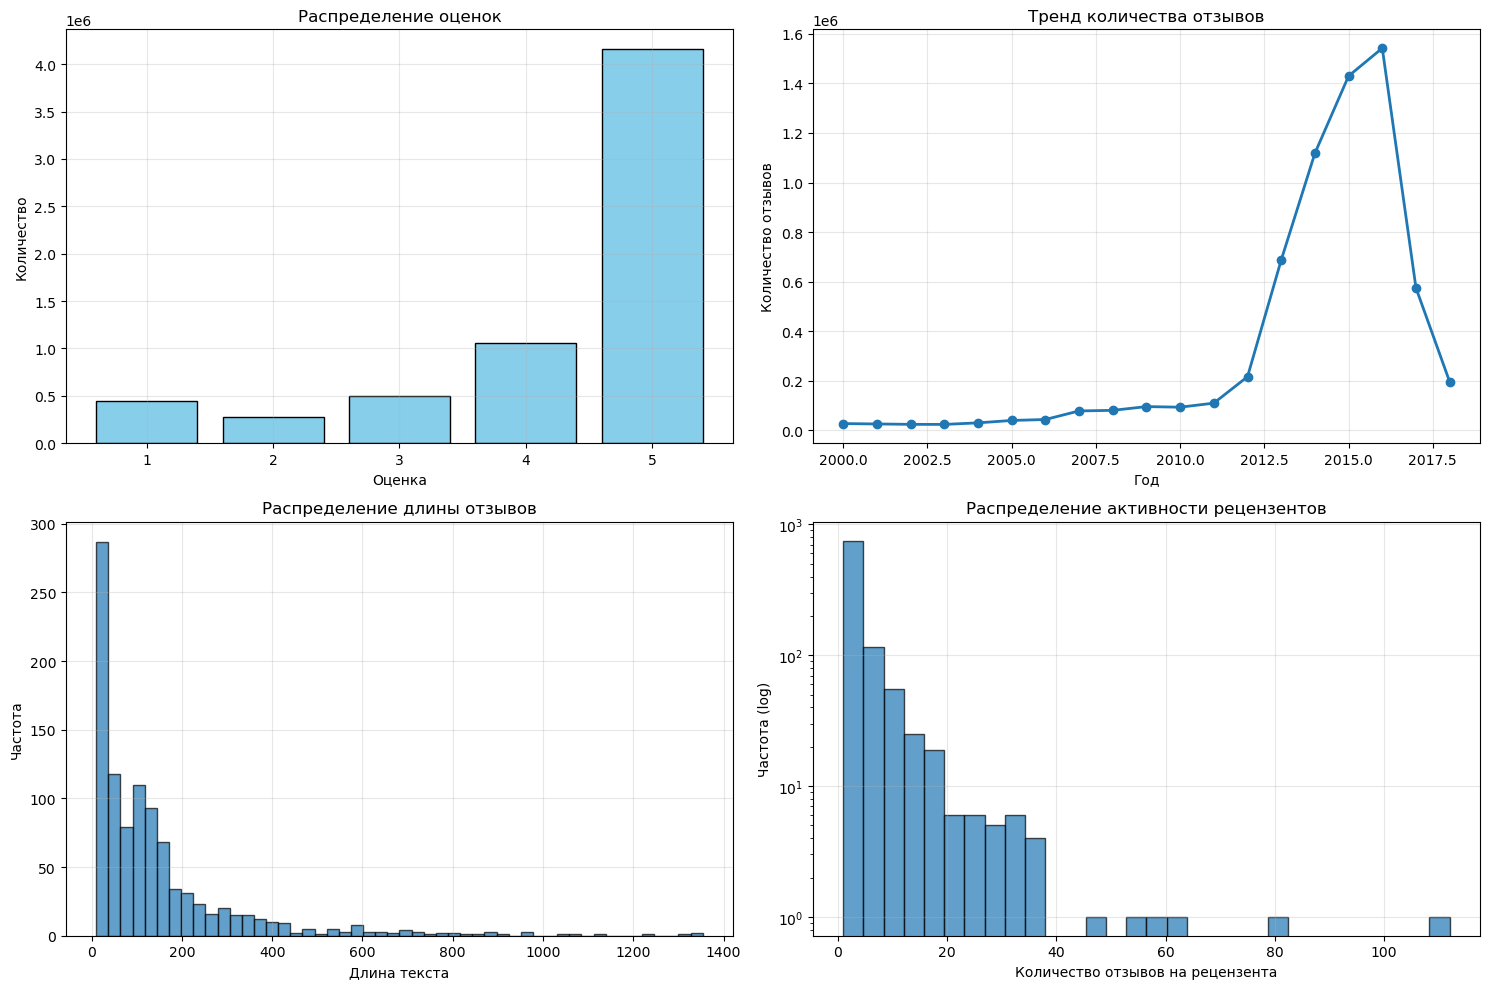

In [83]:
print("=== ИТОГОВЫЙ АНАЛИЗ ДАННЫХ ===")
print("=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ И ВЫВОДЫ ===\n")

# 1. Создаем числовые признаки для корреляционного анализа
print("1. ПОДГОТОВКА ДАННЫХ ДЛЯ КОРРЕЛЯЦИОННОГО АНАЛИЗА:")
df_correlation = df_final.withColumn("text_length", length("reviewText")) \
                        .withColumn("summary_length", length("summary")) \
                        .withColumn("review_year", year(from_unixtime("unixReviewTime")))

# 2. Корреляционная матрица для числовых признаков
print("\n2. КОРРЕЛЯЦИОННАЯ МАТРИЦА ЧИСЛОВЫХ ПРИЗНАКОВ:")
numeric_columns = ["overall", "text_length", "summary_length", "review_year"]

correlation_matrix = {}
for col1 in numeric_columns:
    correlation_matrix[col1] = {}
    for col2 in numeric_columns:
        corr_value = df_correlation.select(corr(col1, col2)).collect()[0][0]
        correlation_matrix[col1][col2] = corr_value

# Преобразуем в DataFrame Pandas для визуализации
corr_matrix_pd = pd.DataFrame(correlation_matrix)

# Визуализация тепловой карты корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', linewidths=0.5)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

# 3. Анализ ключевых корреляций
print("\n3. АНАЛИЗ КЛЮЧЕВЫХ КОРРЕЛЯЦИЙ:")
print("Наиболее значимые корреляции:")
significant_correlations = []

for i, col1 in enumerate(numeric_columns):
    for j, col2 in enumerate(numeric_columns):
        if i < j:  # избегаем дублирования
            corr_val = correlation_matrix[col1][col2]
            if abs(corr_val) > 0.05:  # значимые корреляции
                significant_correlations.append((col1, col2, corr_val))

# Сортируем по абсолютному значению
significant_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

for col1, col2, corr_val in significant_correlations:
    direction = "положительная" if corr_val > 0 else "отрицательная"
    print(f"{col1} ↔ {col2}: {corr_val:.4f} ({direction})")

# 4. Статистика по всем столбцам
print("\n4. ИТОГОВАЯ СТАТИСТИКА ПО ВСЕМ СТОЛБЦАМ:")
print(f"Общее количество отзывов: {df_final.count():,}")
print(f"Период данных: 2000-2018 ({df_correlation.agg(max('review_year')).collect()[0][0] - 2000 + 1} лет)")
print(f"Уникальных продуктов: {df_final.select('asin').distinct().count():,}")
print(f"Уникальных рецензентов: {df_final.select('reviewerID').distinct().count():,}")

# 5. Качество данных - итоговая оценка
print("\n5. ОЦЕНКА КАЧЕСТВА ДАННЫХ:")
quality_metrics = {
    "NULL в ключевых полях": 0,
    "Некорректные ASIN": 0,
    "Некорректные оценки": 0,
    "Некорректные даты": 0,
    "Дубликаты отзывов": 3617
}

print("Проблемы качества данных:")
for metric, count in quality_metrics.items():
    percentage = (count / df_final.count()) * 100
    print(f"  {metric}: {count} ({percentage:.4f}%)")

# 6. Визуализация распределения ключевых показателей
print("\n6. ВИЗУАЛИЗАЦИЯ КЛЮЧЕВЫХ ПОКАЗАТЕЛЕЙ:")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение оценок
rating_dist = df_final.groupBy("overall").count().orderBy("overall").toPandas()
axes[0, 0].bar(rating_dist["overall"], rating_dist["count"], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel("Оценка")
axes[0, 0].set_ylabel("Количество")
axes[0, 0].set_title("Распределение оценок")
axes[0, 0].grid(True, alpha=0.3)

# Распределение по годам
year_dist = df_correlation.groupBy("review_year").count().orderBy("review_year").toPandas()
axes[0, 1].plot(year_dist["review_year"], year_dist["count"], marker='o', linewidth=2)
axes[0, 1].set_xlabel("Год")
axes[0, 1].set_ylabel("Количество отзывов")
axes[0, 1].set_title("Тренд количества отзывов")
axes[0, 1].grid(True, alpha=0.3)

# Длина текста отзывов
text_length_sample = df_correlation.select("text_length").sample(0.01).limit(1000).toPandas()
axes[1, 0].hist(text_length_sample["text_length"], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel("Длина текста")
axes[1, 0].set_ylabel("Частота")
axes[1, 0].set_title("Распределение длины отзывов")
axes[1, 0].grid(True, alpha=0.3)

# Активность рецензентов
reviewer_activity = df_final.groupBy("reviewerID").count()
activity_sample = reviewer_activity.select("count").sample(0.1).limit(1000).toPandas()
axes[1, 1].hist(activity_sample["count"], bins=30, edgecolor='black', alpha=0.7, log=True)
axes[1, 1].set_xlabel("Количество отзывов на рецензента")
axes[1, 1].set_ylabel("Частота (log)")
axes[1, 1].set_title("Распределение активности рецензентов")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Сохраняем данные

In [84]:
output_path_cleaned = "hdfs://hadoop-namenode:9820/data/mattiev_database/movies_lab1_cleaned"

df_final.write \
  .mode("overwrite") \
  .option("compression", "snappy") \
  .parquet(output_path_cleaned)

print(f"Очищенные данные сохранены в: {output_path_cleaned}")

Очищенные данные сохранены в: hdfs://hadoop-namenode:9820/data/mattiev_database/movies_lab1_cleaned


In [85]:
spark.stop()